# Extension Plan - Forecasting

In this notebook, I use the VARMAX model to forecast how the different health indicators would be affected in the next 25 years. I utilize the previously forecasted smoke estimates to aid with this prediction.

In [86]:
#
#    IMPORTS
#

#    These are standard python modules. In case you do not have a python module, you should use `!pip install <module>`
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error
import numpy as np


First, I load all the required data and create a single table out of it to help with the modelling

In [87]:

mortality_data = pd.read_csv("../Processed Data/1999_2020_Mortality_Data.csv")
smoke_estimate_aqi_data = pd.read_csv("../Processed Data/smoke_estimate_with_year_aqi.csv", index_col=0)
respiratory_therapy_data = pd.read_csv("../Processed Data/2000_2015_respiratory_therapy.csv")
respiratory_operations_data = pd.read_csv("../Processed Data/2000_2020_respiratory_system_operations.csv")
emergency_visit_data = pd.read_csv("../Processed Data/2003_2021_emergency_visits_data.csv")
inpatient_discharges_data = pd.read_csv("../Processed Data/2003_2021_inpatient_discharge_data.csv")
smoke_predictions = pd.read_csv("../Processed Data/smoke_estimate_predictions.csv")


In [88]:
mortality_aggregated_by_year = mortality_data.groupby('Year').agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_year.rename(columns={'Deaths': 'Respiratory Mortality'}, inplace=True)

smoke_estimate_aqi_data.rename(columns={'Fire_Year': 'Year'}, inplace=True)
respiratory_therapy_data.rename(columns={'Total': 'Procedures - Respiratory Therapy'}, inplace=True)
respiratory_operations_data.rename(columns={'Total': 'Procedures - Respiratory Operations'}, inplace=True)
#mortality_aggregated_by_Age = mortality_data.groupby(['Year', 'Age Groups']).agg({'Deaths': 'sum'}).reset_index()
#mortality_aggregated_by_Gender = mortality_data.groupby(['Year', 'Gender']).agg({'Deaths': 'sum'}).reset_index()
emergency_visits_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
emergency_visits_aggregated_by_year.rename(columns={'Asthma, All Mentions': 'Emergency Visits - Asthma All Mentions'}, inplace=True)
inpatient_discharges_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
inpatient_discharges_aggregated_by_year.rename(columns={'Asthma, All Mentions': 'Inpatient Discharges - Asthma All Mentions'}, inplace=True)

In [89]:
# Merging the dataframes
dfs = [smoke_estimate_aqi_data, mortality_aggregated_by_year, respiratory_therapy_data, respiratory_operations_data, emergency_visits_aggregated_by_year, inpatient_discharges_aggregated_by_year]
result = dfs[0]

for df in dfs[1:]:
    result = pd.merge(result, df, on='Year', how='outer')

result


,Year,Smoke_Estimate,yearly_avg_aqi,Respiratory Mortality,Procedures - Respiratory Therapy,Procedures - Respiratory Operations,Emergency Visits - Asthma All Mentions,Inpatient Discharges - Asthma All Mentions
0,1964,4.341713,5.386648,NaN,NaN,NaN,NaN,NaN
1,1965,4.000000,6.132075,NaN,NaN,NaN,NaN,NaN
2,1966,6.274285,4.641221,NaN,NaN,NaN,NaN,NaN
3,1967,7.693339,53.584158,NaN,NaN,NaN,NaN,NaN
4,1968,6.949404,63.722527,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
56,2020,64.000000,45.770657,3239.0,NaN,20724.0,63167.0,29521.0
57,2021,NaN,47.492489,NaN,NaN,NaN,57088.0,30799.0
58,2022,NaN,40.919786,NaN,NaN,NaN,NaN,NaN
59,2023,NaN,44.967453,NaN,NaN,NaN,NaN,NaN


Now, since most of the health indicators data is between 1999 and 2022, I filter the data to those years

In [90]:
result = result[(result["Year"] >= 1999) & (result["Year"] <= 2022)]
result

,Year,Smoke_Estimate,yearly_avg_aqi,Respiratory Mortality,Procedures - Respiratory Therapy,Procedures - Respiratory Operations,Emergency Visits - Asthma All Mentions,Inpatient Discharges - Asthma All Mentions
35,1999,20.482623,54.849141,2434.0,NaN,NaN,NaN,NaN
36,2000,27.482062,51.371458,2457.0,6788.0,7964.0,NaN,NaN
37,2001,21.431882,49.290578,2379.0,7220.0,8953.0,NaN,NaN
38,2002,21.553465,53.063240,2443.0,7801.0,9507.0,NaN,NaN
39,2003,22.090325,53.228136,2364.0,10682.0,10061.0,15395.0,10057.0
40,2004,18.821474,45.149172,2245.0,9819.0,10951.0,32405.0,21050.0
41,2005,32.035572,47.915494,2641.0,11796.0,11804.0,42054.0,23037.0
42,2006,38.829661,47.896634,2487.0,12290.0,12709.0,44403.0,23588.0
43,2007,30.907773,47.032512,2215.0,12970.0,13075.0,45697.0,24349.0
44,2008,29.935974,47.256230,2428.0,14531.0,13985.0,52785.0,26121.0


c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


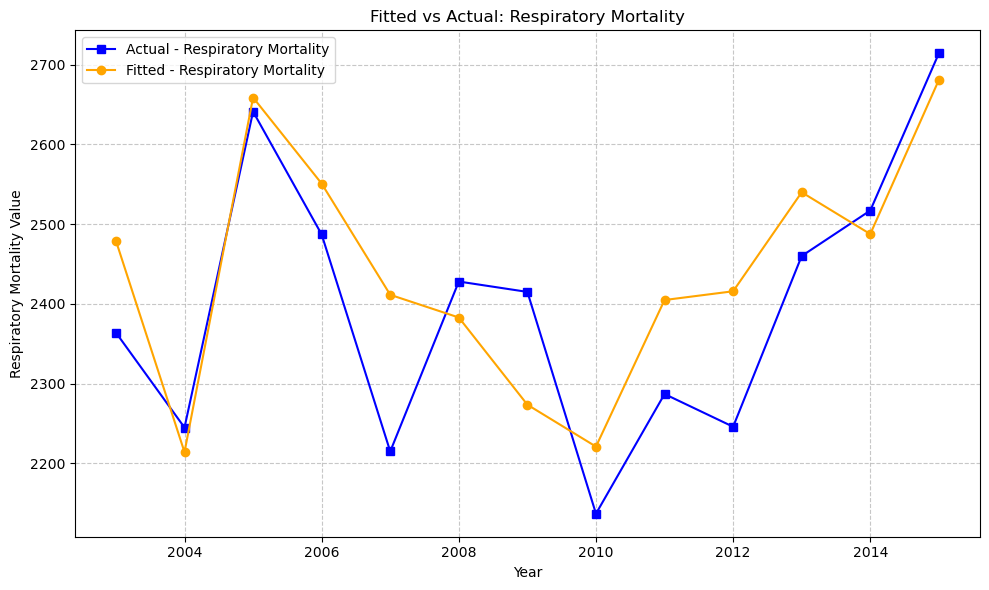

Respiratory Mortality - RMSE: 102.77, Relative RMSE: 4.29%



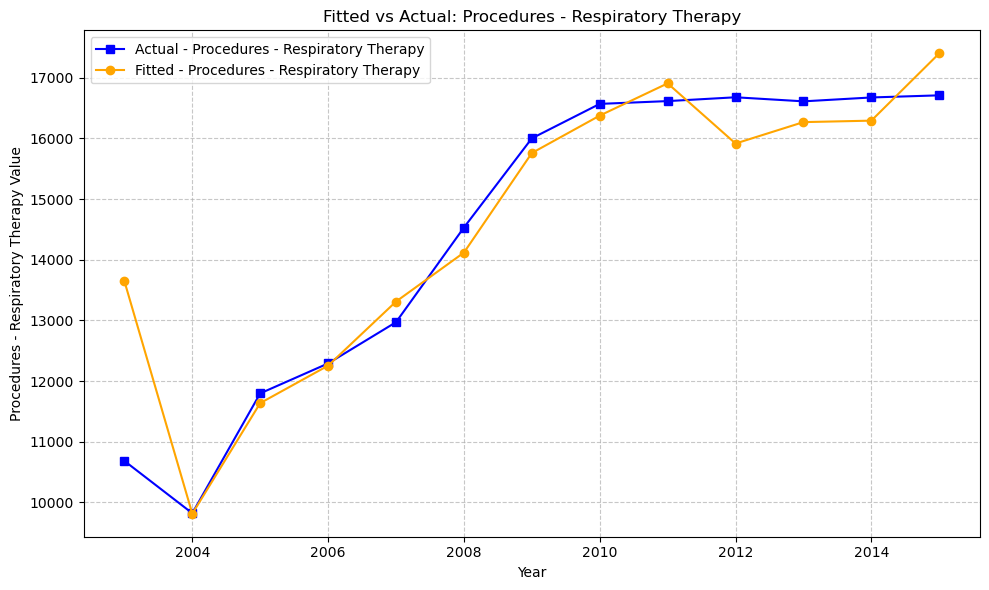

Procedures - Respiratory Therapy - RMSE: 903.43, Relative RMSE: 6.25%



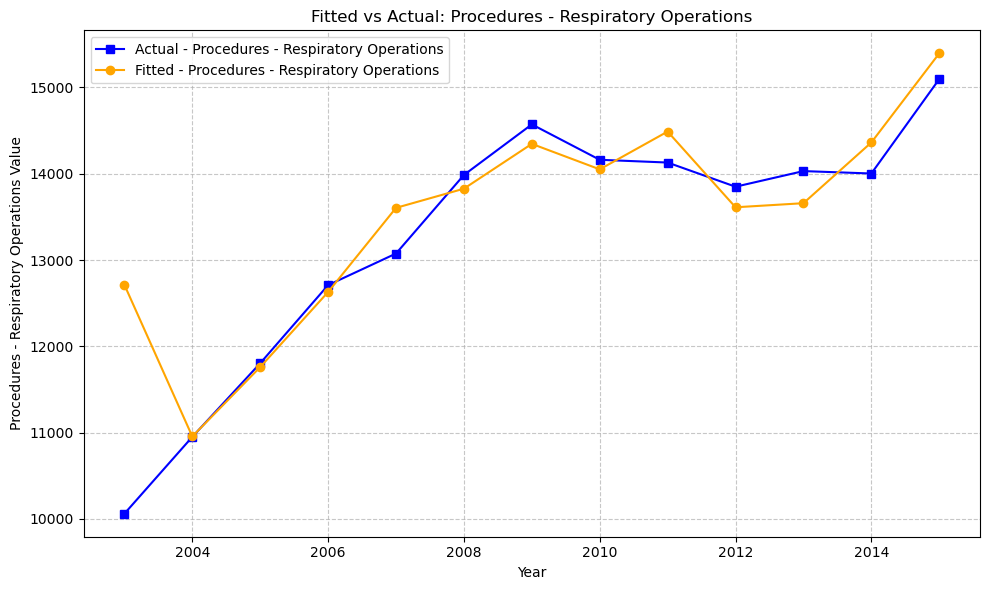

Procedures - Respiratory Operations - RMSE: 782.01, Relative RMSE: 5.90%



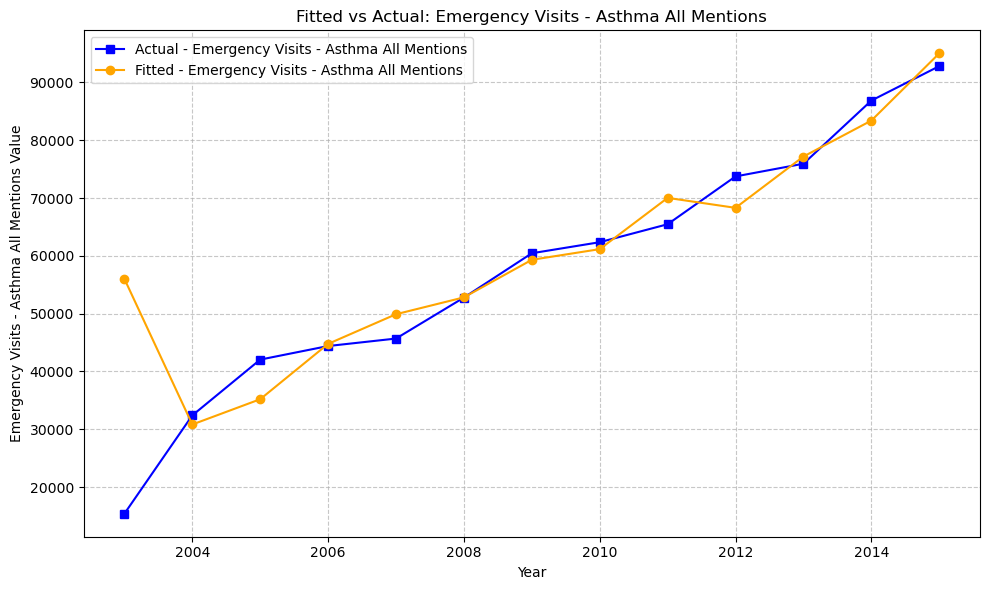

Emergency Visits - Asthma All Mentions - RMSE: 11733.98, Relative RMSE: 20.33%



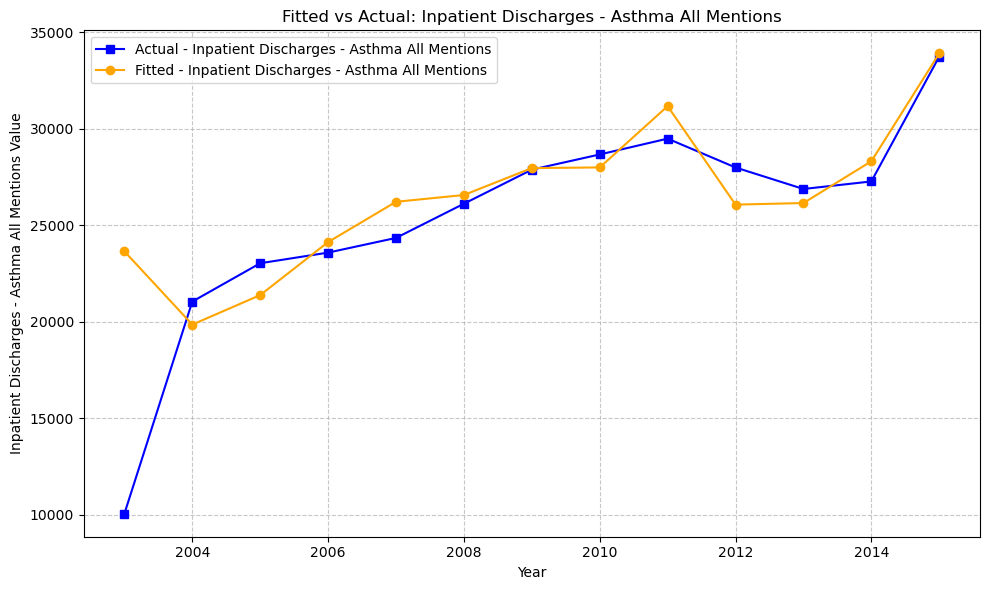

Inpatient Discharges - Asthma All Mentions - RMSE: 3938.77, Relative RMSE: 15.51%



In [91]:
# Define endogenous (target) and exogenous (predictor) variables
endog = result[['Respiratory Mortality', 'Procedures - Respiratory Therapy', 
                'Procedures - Respiratory Operations', 'Emergency Visits - Asthma All Mentions', 
                'Inpatient Discharges - Asthma All Mentions']]
exog = result[['Smoke_Estimate']]

# Drop rows with missing values
endog = endog.dropna()
exog = exog.loc[endog.index]

# Standardize endogenous variables
scaler = StandardScaler()
endog_scaled = pd.DataFrame(scaler.fit_transform(endog), 
                            columns=endog.columns, 
                            index=endog.index)

# Fit the VARMAX model
model = VARMAX(endog_scaled, exog=exog, order=(1, 2))  # Adjust order (p, q) as needed
fitted_model = model.fit(disp=False)

# Fitted values
fitted_values = fitted_model.fittedvalues

# Inverse transform fitted and actual values to original scale
fitted_values_original = pd.DataFrame(scaler.inverse_transform(fitted_values), 
                                      columns=endog.columns, 
                                      index=endog.index)
endog_original = pd.DataFrame(scaler.inverse_transform(endog_scaled), 
                              columns=endog.columns, 
                              index=endog.index)

# Assuming your dataset has a 'Year' column:
year_column = result.loc[endog.index, 'Year']  # Filter year_column to match endog indices

# Plot fitted vs actual for each indicator
for column in endog.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(year_column, endog_original[column], label=f'Actual - {column}', color='blue', marker='s')
    plt.plot(year_column, fitted_values_original[column], label=f'Fitted - {column}', color='orange', marker='o')
    plt.title(f'Fitted vs Actual: {column}')
    
    # Add axis labels
    plt.xlabel('Year')  # X-axis is now based on the 'Year' column
    plt.ylabel(f'{column} Value')  # Y-axis label (each column has its own label)

    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # RMSE Evaluation
    rmse = np.sqrt(mean_squared_error(endog_original[column], fitted_values_original[column]))
    relative_rmse = rmse / endog_original[column].mean()
    print(f"{column} - RMSE: {rmse:.2f}, Relative RMSE: {relative_rmse:.2%}")
    print("\n================================================================================================")


    Smoke_Estimate
52       37.031446
53       43.473244
54       40.725523
55       37.441863
56       64.000000
    Smoke_Estimate
0        37.031446
1        43.473244
2        40.725523
3        37.441863
4        64.000000
5        50.215578
6        50.189524
7        50.179607
8        50.175831
9        50.174394
10       50.173847
11       50.173639
12       50.173560
13       50.173530
14       50.173518
15       50.173514
16       50.173512
17       50.173511
18       50.173511
19       50.173511
20       50.173511
21       50.173511
22       50.173511
23       50.173511
24       50.173511
25       50.173511
26       50.173511
27       50.173511
28       50.173511
29       50.173511
30       50.173511
31       50.173511
32       50.173511
33       50.173511
34       50.173511


c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation 

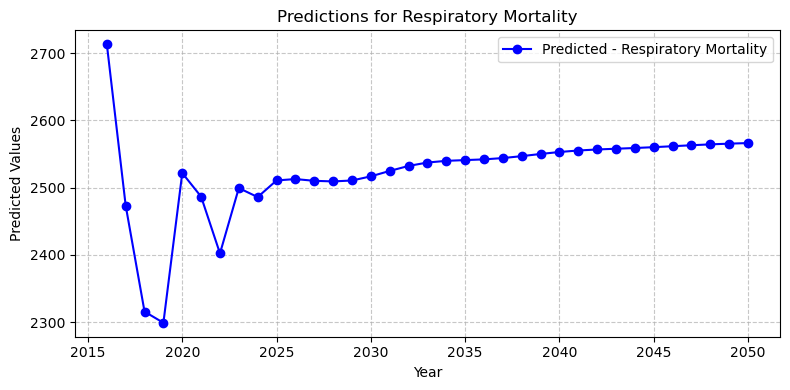

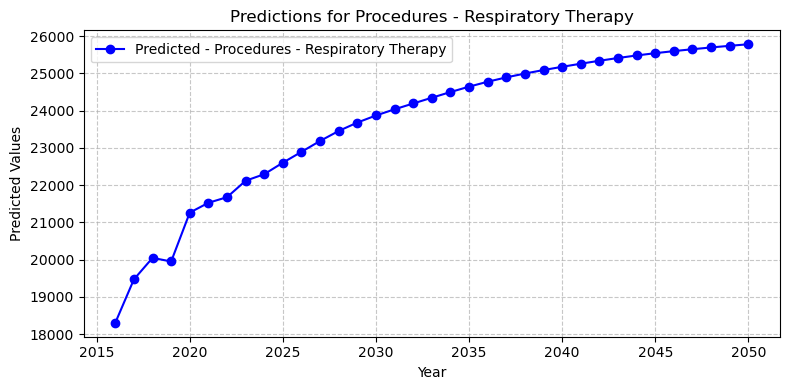

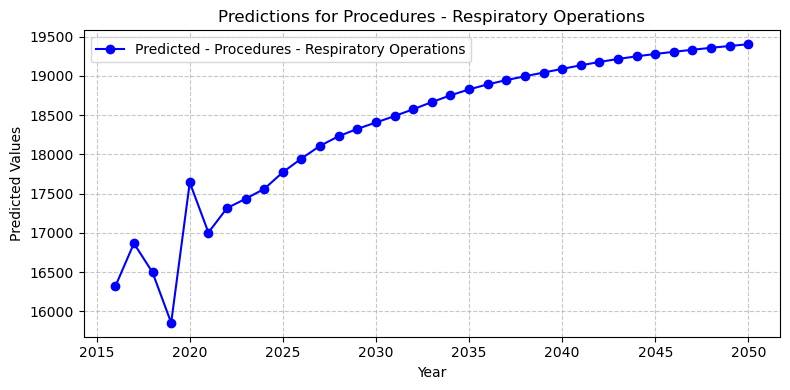

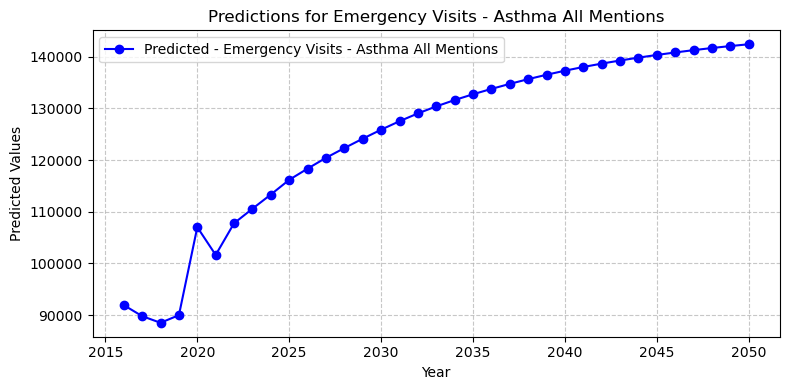

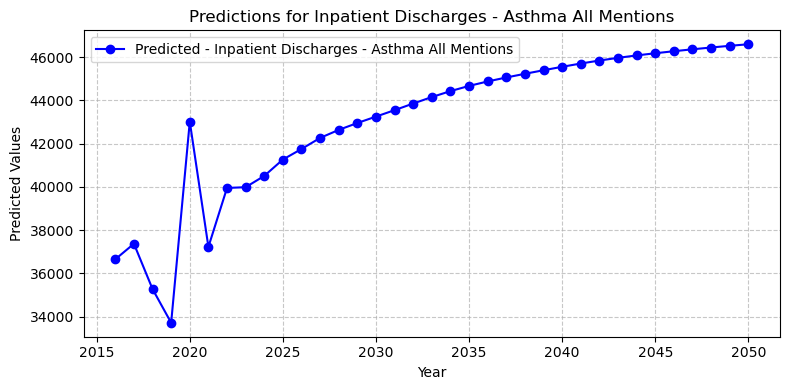

In [92]:
# Prepare exogenous data for predictions

# 1. Extract Smoke Estimates for 2016-2020 from `smoke_estimate_aqi_data`
exog_2016_2020 = smoke_estimate_aqi_data[(smoke_estimate_aqi_data["Year"] >= 2016) & (smoke_estimate_aqi_data["Year"] <= 2020)]
exog_2016_2020 = exog_2016_2020[['Smoke_Estimate']]
print(exog_2016_2020)
# 2. Extract Smoke Estimates for 2021-2050 from `smoke_predictions`
exog_2021_2050 = smoke_predictions[['Smoke_Estimate']]  # Already aligned for years 2021-2050

#print(exog_2021_2050)

# 3. Combine both datasets into a single exogenous dataset for years 2016-2050
exog_new = pd.concat([exog_2016_2020, exog_2021_2050], axis=0).reset_index(drop=True)
print(exog_new)

# Predict future values (the length should be from 2016 to 2050)
# Ensure the forecast length matches the length of the combined data
predictions = fitted_model.get_forecast(steps=len(exog_new), exog=exog_new)

# Extract the predicted values
predicted_values = predictions.predicted_mean

# Inverse transform the predicted values to original scale
predicted_values_original = scaler.inverse_transform(predicted_values)

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame(predicted_values_original, columns=endog.columns)

# For the year column, we need to create a range from 2016 to 2050
predicted_df['Year'] = range(2016, 2051)

# Plot future predictions for each indicator
for column in endog.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(predicted_df['Year'], predicted_df[column], label=f'Predicted - {column}', color='blue', marker='o')
    plt.title(f'Predictions for {column}')
    plt.xlabel('Year')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


C:\Users\mihir\AppData\Local\Temp\ipykernel_33796\3167766018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered['Year'] = pd.to_datetime(result_filtered['Year'], format='%Y')
c:\Users\mihir\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was 

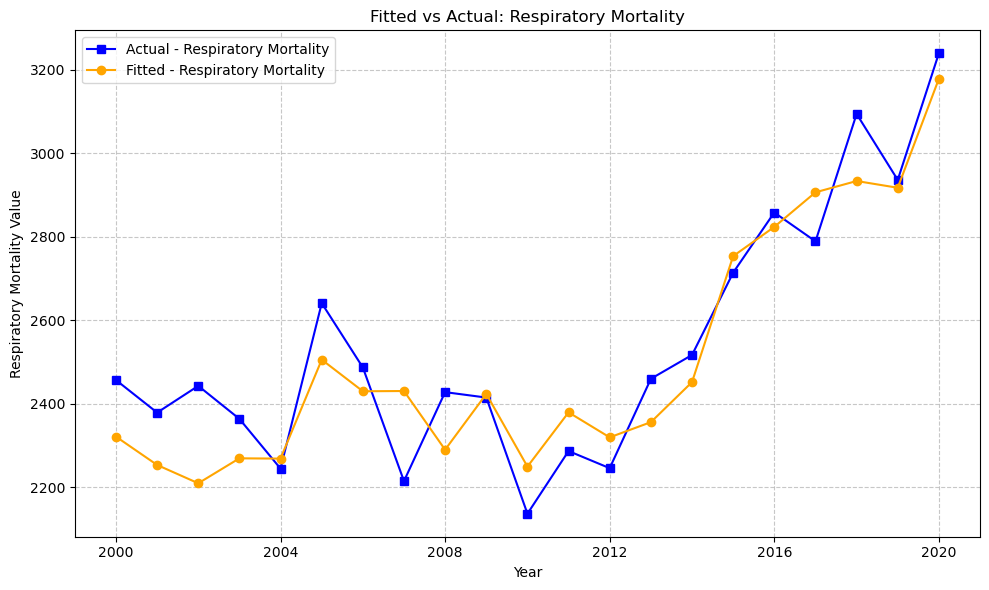

Respiratory Mortality - RMSE: 114.06, Relative RMSE: 4.49%



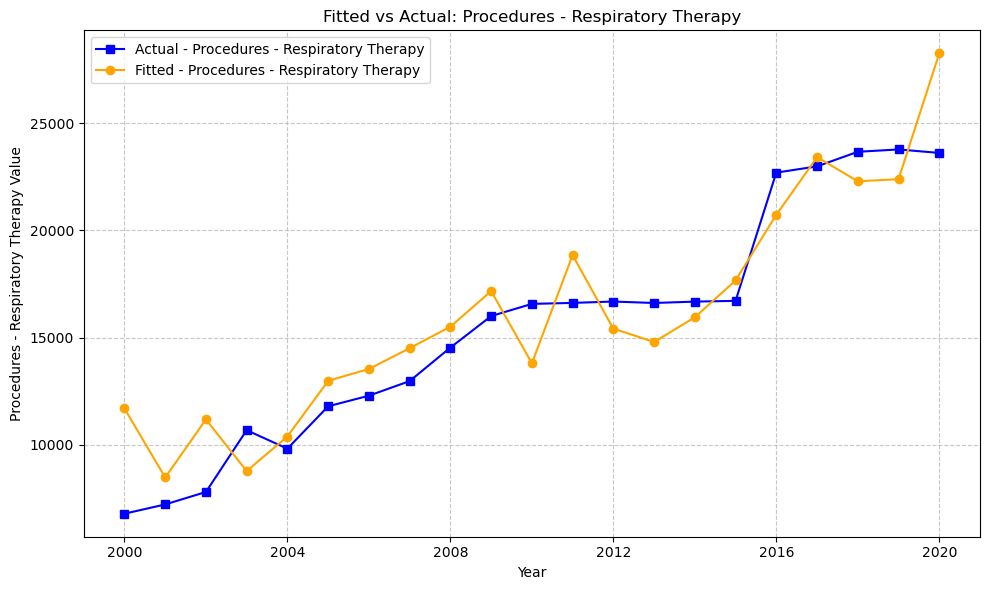

Procedures - Respiratory Therapy - RMSE: 2150.17, Relative RMSE: 13.83%



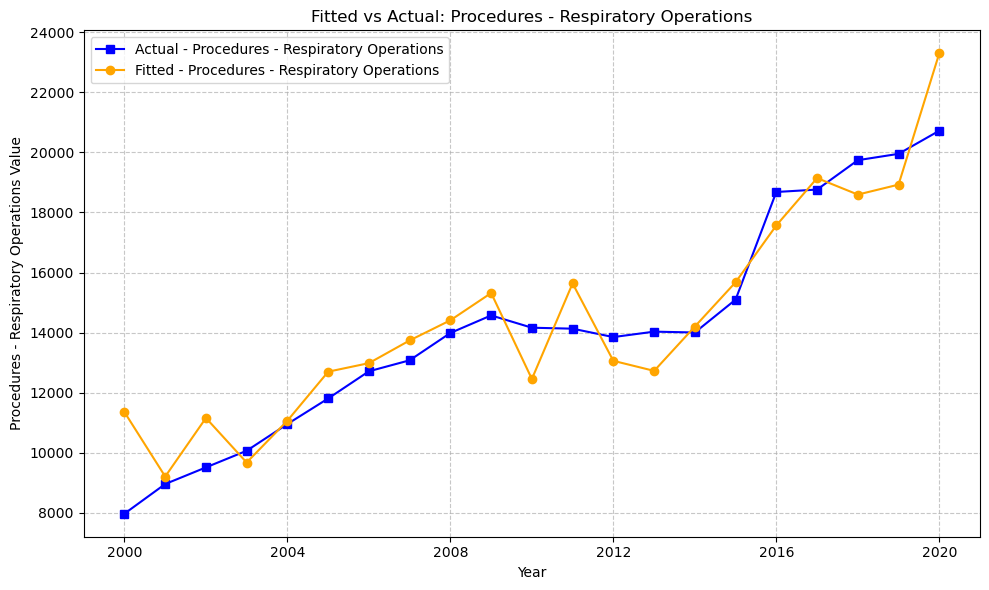

Procedures - Respiratory Operations - RMSE: 1286.72, Relative RMSE: 9.11%



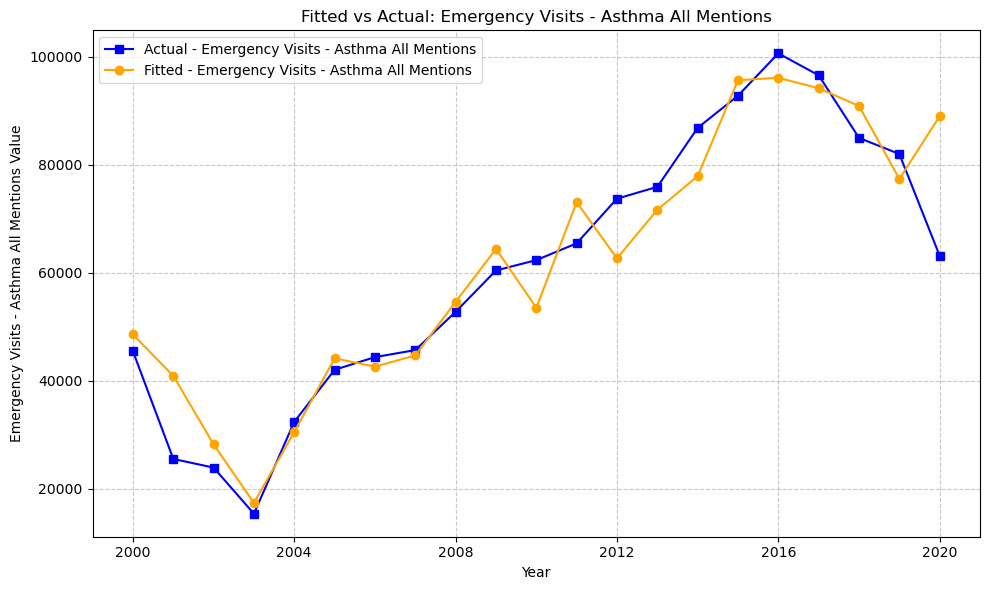

Emergency Visits - Asthma All Mentions - RMSE: 8211.00, Relative RMSE: 13.55%



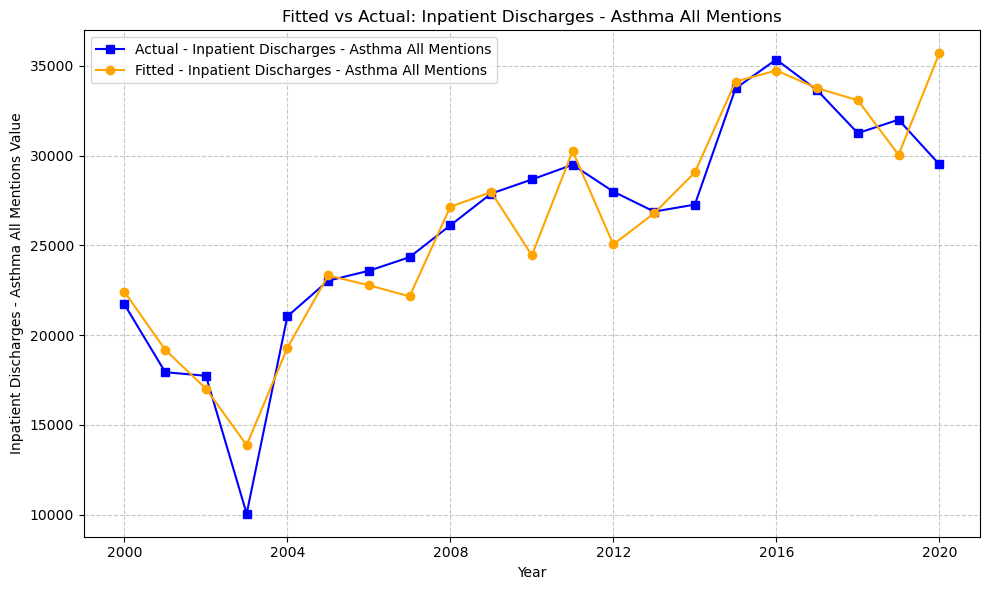

Inpatient Discharges - Asthma All Mentions - RMSE: 2215.70, Relative RMSE: 8.47%



c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation 

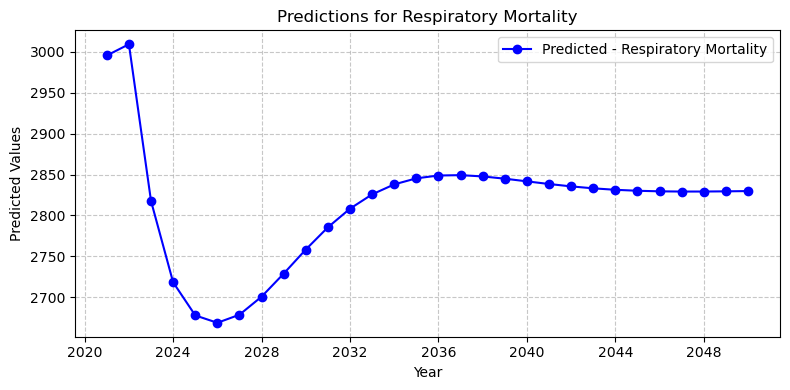

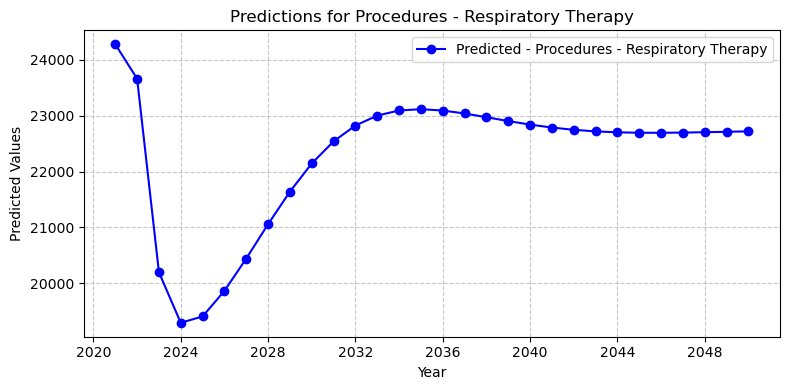

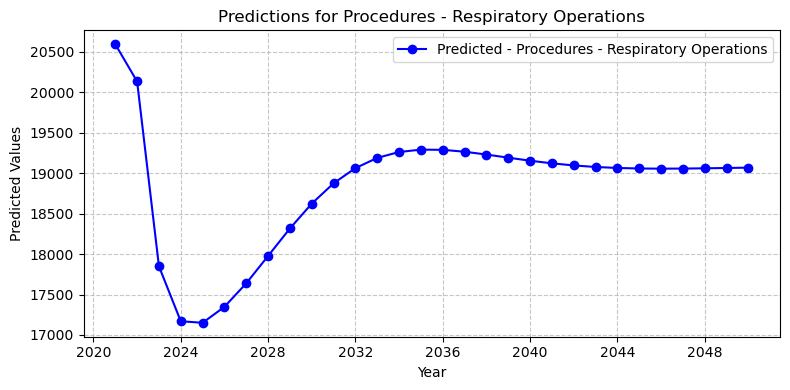

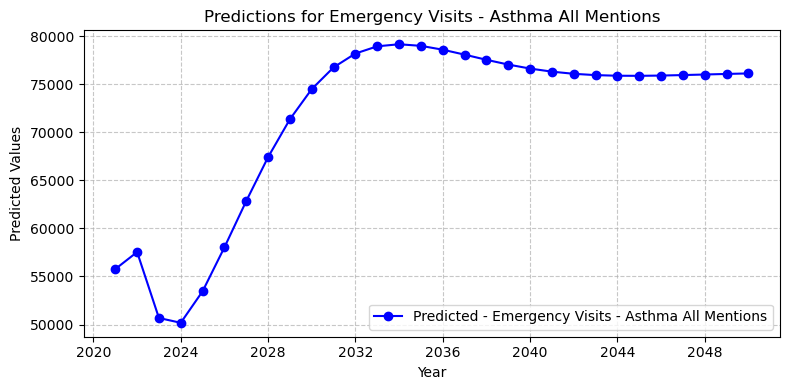

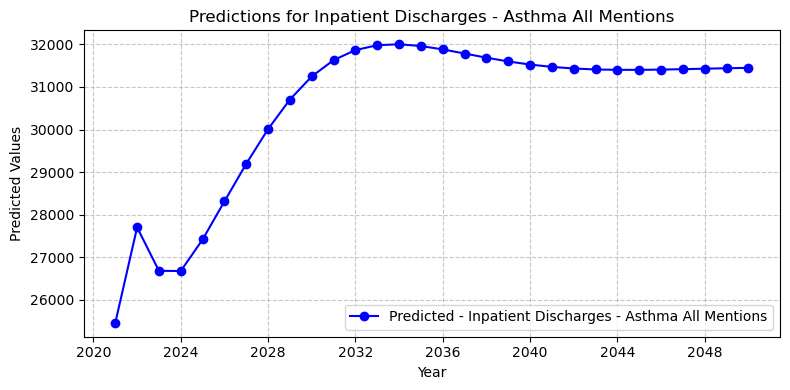

In [93]:
# Filter the data for the years 2000-2020
result_filtered = result[(result['Year'] >= 2000) & (result['Year'] <= 2020)]

# Ensure 'Year' is in datetime format
result_filtered['Year'] = pd.to_datetime(result_filtered['Year'], format='%Y')

# Define endogenous (target) and exogenous (predictor) variables
endog = result_filtered[['Respiratory Mortality', 'Procedures - Respiratory Therapy', 
                         'Procedures - Respiratory Operations', 'Emergency Visits - Asthma All Mentions', 
                         'Inpatient Discharges - Asthma All Mentions']]
exog = result_filtered[['Smoke_Estimate']]
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Define the imputer model (e.g., BayesianRidge used internally)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values in the endogenous variables using IterativeImputer
endog_imputed = pd.DataFrame(imputer.fit_transform(endog), columns=endog.columns, index=endog.index)

# Now you can proceed with the rest of the process as before


# Proceed with your model fitting and evaluation
# Standardize endogenous variables
scaler = StandardScaler()
endog_scaled = pd.DataFrame(scaler.fit_transform(endog_imputed), 
                            columns=endog_imputed.columns, 
                            index=endog_imputed.index)

# Fit the VARMAX model
model = VARMAX(endog_scaled, exog=exog, order=(1, 2))  # Adjust order (p, q) as needed
fitted_model = model.fit(disp=False)

# Fitted values
fitted_values = fitted_model.fittedvalues

# Inverse transform fitted and actual values to original scale
fitted_values_original = pd.DataFrame(scaler.inverse_transform(fitted_values), 
                                      columns=endog_imputed.columns, 
                                      index=endog_imputed.index)
endog_original = pd.DataFrame(scaler.inverse_transform(endog_scaled), 
                              columns=endog_imputed.columns, 
                              index=endog_imputed.index)

# Assuming your dataset has a 'Year' column and is already in datetime format:
year_column = result_filtered.loc[endog_imputed.index, 'Year']  # Filter year_column to match endog indices

# Plot fitted vs actual for each indicator
for column in endog_imputed.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(year_column, endog_original[column], label=f'Actual - {column}', color='blue', marker='s')
    plt.plot(year_column, fitted_values_original[column], label=f'Fitted - {column}', color='orange', marker='o')
    plt.title(f'Fitted vs Actual: {column}')
    
    # Add axis labels
    plt.xlabel('Year')  # X-axis is now based on the 'Year' column
    plt.ylabel(f'{column} Value')  # Y-axis label (each column has its own label)

    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # RMSE Evaluation
    rmse = np.sqrt(mean_squared_error(endog_original[column], fitted_values_original[column]))
    relative_rmse = rmse / endog_original[column].mean()
    print(f"{column} - RMSE: {rmse:.2f}, Relative RMSE: {relative_rmse:.2%}")
    print("\n================================================================================================")         

# Prepare exogenous data for predictions
exog_new = smoke_predictions[['Smoke_Estimate']]

# Predict future values
predictions = fitted_model.get_forecast(steps=len(exog_new), exog=exog_new)
predicted_values = predictions.predicted_mean

# Inverse transform predictions
predicted_values_original = scaler.inverse_transform(predicted_values)
predicted_df = pd.DataFrame(predicted_values_original, 
                            columns=endog_imputed.columns)

# Convert Year in predictions to datetime format (if not already in datetime)
predicted_df['Year'] = pd.to_datetime(smoke_predictions['Year'], format='%Y')

# Plot future predictions for each indicator
for column in endog_imputed.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(predicted_df['Year'], predicted_df[column], label=f'Predicted - {column}', color='blue', marker='o')
    plt.title(f'Predictions for {column}')
    plt.xlabel('Year')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
